In [110]:
# Import required libraries
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# OSMNX configuration
ox.settings.use_cache = True        # Use cache to speed up loading
ox.settings.log_console = True      # Show logs for debugging

In [111]:
# Define area and road types to analyze
PLACE_NAME = 'Tan Binh District, Ho Chi Minh City, Vietnam'
BIG_ROAD_TYPES = ['primary', 'secondary', 'tertiary', 'trunk']

# Load full data from OpenStreetMap (including all streets)
G_full = ox.graph_from_place(PLACE_NAME, network_type='drive')
edges_full = ox.graph_to_gdfs(G_full, nodes=False)
print(f"So doan duong tong cong: {len(edges_full)}")

So doan duong tong cong: 3819


In [112]:
# Function to process road names
def fix_name(val):
    """Standardize road names from OSM data"""
    if isinstance(val, list): 
        return str(val[0]) if len(val) > 0 else ""
    if pd.isna(val): 
        return ""
    return str(val)

# Function to process road lengths
def fix_length(val):
    """Standardize road lengths from OSM data"""
    if isinstance(val, list):
        return sum([float(x) for x in val if isinstance(x, (int, float))])
    try:
        return float(val)
    except (TypeError, ValueError):
        return 0.0

# Process all edges
edges_all = edges_full.copy()
edges_all['name'] = edges_all['name'].apply(fix_name)
edges_all['length'] = edges_all['length'].apply(fix_length)
edges_all = edges_all[edges_all['length'] > 0]

# Also keep track of major roads for analysis
edges_big = edges_all[
    (edges_all['name'].notna()) &
    (edges_all['highway'].isin(BIG_ROAD_TYPES))
].reset_index()

# Display field information
FIELDS_OF_INTEREST = ['name', 'length', 'width', 'lanes', 'maxspeed', 'highway']
cols_exist = [f for f in FIELDS_OF_INTEREST if f in edges_all.columns]
print("\nMau du lieu cac tuyen duong:")
print(edges_all[cols_exist].head(8))

# Data availability statistics
print("\nThong ke du lieu:")
for field in ['width', 'lanes', 'maxspeed']:
    if field in edges_all.columns:
        count = edges_all[field].notna().sum()
        print(f"[{field}] Co {count} doan co du lieu")


Mau du lieu cac tuyen duong:
                                              name      length width lanes  \
u         v           key                                                    
366367322 6257994043  0    Hẻm 97 Nguyễn Thái Bình   49.470965   NaN   NaN   
          11361818084 0           Nguyễn Thái Bình   91.724411   NaN     2   
          6257994039  0           Nguyễn Thái Bình    6.287150   NaN     2   
366367617 7940859504  0                   Cửu Long   50.045679   NaN   NaN   
          366468721   0                   Cửu Long  148.028343   NaN   NaN   
          2077773883  0                    Lam Sơn   96.818305   NaN   NaN   
          5735306183  0                    Lam Sơn  109.270337   NaN   NaN   
366367660 366379315   0                  Bàu Cát 6  235.750954   NaN   NaN   

                          maxspeed      highway  
u         v           key                        
366367322 6257994043  0        NaN  residential  
          11361818084 0        NaN     

In [113]:
# Create graphs for visualization and analysis
G_big = G_full.copy()

# Keep track of major roads for analysis
edges_rm = []
for u, v, k, data in G_big.edges(keys=True, data=True):
    # Mark edges that are not major roads
    if ('highway' not in data or data['highway'] not in BIG_ROAD_TYPES):
        data['is_major'] = False
    else:
        data['is_major'] = True

# Display statistics
major_edges = sum(1 for u, v, k, data in G_big.edges(keys=True, data=True) if data.get('is_major', False))
total_edges = len(G_big.edges)
print(f"Tong so doan duong: {total_edges}")
print(f"So doan duong chinh: {major_edges}")
print(f"So doan duong nho: {total_edges - major_edges}")

Tong so doan duong: 3819
So doan duong chinh: 1140
So doan duong nho: 2679


In [114]:
# Configuration parameters
MIN_INTERSECTION_DEGREE = 3  # Minimum number of branches to consider as major intersection

# Find major intersections
hotspots = []
for node_id, deg in dict(G_big.degree()).items():
    if deg >= MIN_INTERSECTION_DEGREE:
        node_data = G_big.nodes[node_id]
        hotspots.append({
            'node_id': node_id,
            'vi do': node_data['y'],
            'kinh do': node_data['x'],
            'degree': deg,
            'loai': f"Nga {deg}"
        })

# Convert to DataFrame and save
df_hotspots = pd.DataFrame(hotspots)
df_hotspots.to_csv("giao_lo_lon_khong_hem.csv", index=False)

# Display results
print("Danh sach cac giao lo lon:")
print(df_hotspots.head(10))

Danh sach cac giao lo lon:
     node_id      vi do     kinh do  degree   loai
0  366367322  10.799133  106.657162       6  Nga 6
1  366367617  10.810271  106.666859       8  Nga 8
2  366367660  10.790142  106.643264       8  Nga 8
3  366368733  10.796539  106.652559       6  Nga 6
4  366369484  10.796429  106.664386       6  Nga 6
5  366369902  10.805858  106.641099       6  Nga 6
6  366369976  10.792617  106.659867       4  Nga 4
7  366370841  10.814668  106.671980       4  Nga 4
8  366370884  10.779642  106.644526       6  Nga 6
9  366371936  10.790220  106.640794       4  Nga 4


In [115]:
# Define fields to group and aggregate
GROUP_BY_FIELDS = ['name']
AGGREGATION_DICT = {'length': 'sum'}

def merge_unique(x):
    """Merge unique values and sort them"""
    out = set()
    for i in x.dropna():
        if isinstance(i, list):
            out |= set(str(s) for s in i if pd.notnull(s))
        else:
            out.add(str(i))
    return ', '.join(sorted(out)) if len(out) > 0 else ""

# Add optional fields if they exist
OPTIONAL_FIELDS = ['width', 'lanes', 'maxspeed']
for field in OPTIONAL_FIELDS:
    if field in edges_big.columns:
        AGGREGATION_DICT[field] = merge_unique

# Group data by road name
report_big = edges_big.groupby(GROUP_BY_FIELDS).agg(AGGREGATION_DICT).reset_index()

# Rename columns for readability
report_big = report_big.rename(columns={
    'name': 'Ten duong',
    'length': 'Tong chieu dai (m)'
})

# Save and display results
report_big.to_csv('tuyen_lon_socap.csv', index=False)
print("Thong ke cac tuyen duong lon:")
print(report_big.head(8))

Thong ke cac tuyen duong lon:
           Ten duong  Tong chieu dai (m) width    lanes    maxspeed
0                            2271.164931        1, 3, 4  20, 30, 50
1      Bành Văn Trân         1845.728507                           
2            Bàu Cát         1770.740908                           
3          Bàu Cát 4          483.315697                           
4          Bạch Đằng         3705.631550              3          60
5           Bảy Hiền          709.767748                           
6            Bắc Hải          933.763552                           
7  Cách Mạng Tháng 8         2624.439889           1, 2          50


In [116]:
# Mapbox API configuration
import requests

MAPBOX_TOKEN = "pk.eyJ1IjoicXVvY3ZpZXQ5ODA1IiwiYSI6ImNtaGRqNW00NTAzam0ydHExOXYydmZkdXMifQ.0b9gLik_MIklwGf3mQ2wwg"   

def get_mapbox_traffic(lon1, lat1, lon2, lat2):
    """
    Get traffic information from Mapbox API
    Returns:
        speed: km/h
        duration: minutes
        distance: meters
    """
    url = f"https://api.mapbox.com/directions/v5/mapbox/driving-traffic/{lon1},{lat1};{lon2},{lat2}"
    params = {'access_token': MAPBOX_TOKEN}
    
    try:
        r = requests.get(url, params=params)
        data = r.json()
        if 'routes' in data and len(data['routes']) > 0:
            route = data['routes'][0]
            speed = round(route['distance'] / route['duration'] * 3.6, 2)
            duration = route['duration']/60
            distance = route['distance']
            return speed, duration, distance
    except Exception as e:
        print(f"Loi khi goi Mapbox API: {e}")
    
    return None, None, None

# Test API with first road segment
def test_mapbox_api():
    row = edges_big.iloc[0]
    u, v = row['u'], row['v']
    start = G_full.nodes[u]
    end = G_full.nodes[v]
    
    lon1, lat1 = start['x'], start['y']
    lon2, lat2 = end['x'], end['y']
    
    speed, duration, dist = get_mapbox_traffic(lon1, lat1, lon2, lat2)
    if all(x is not None for x in [speed, duration, dist]):
        print(f"Toc do thuc te (Mapbox): {speed} km/h | Thoi gian: {duration:.1f} phut | Chieu dai: {dist:.0f} m")
    else:
        print("Khong lay duoc du lieu tu Mapbox API")

# Run test
test_mapbox_api()

Toc do thuc te (Mapbox): 20.19 km/h | Thoi gian: 0.3 phut | Chieu dai: 92 m


In [117]:
# Load data from CSV files
def load_data():
    """Load and verify data from CSV files"""
    try:
        traffic_data = pd.read_csv('tuyen_lon_socap.csv')
        intersections_data = pd.read_csv('giao_lo_lon_khong_hem.csv')
        return traffic_data, intersections_data
    except Exception as e:
        print(f"Loi khi doc file CSV: {e}")
        return None, None

def analyze_traffic_data(traffic_data):
    """Analyze and display road information"""
    print("=== THONG TIN KET XE TREN CAC TUYEN DUONG LON ===")
    print("-" * 50)
    
    # Sort by length
    traffic_sorted = traffic_data.sort_values('Tong chieu dai (m)', ascending=False).head(10)
    
    print("Top 10 tuyen duong dai nhat (co kha nang ket xe cao):")
    for _, row in traffic_sorted.iterrows():
        print(f"\nTuyen duong: {row['Ten duong']}")
        print(f"Tong chieu dai: {row['Tong chieu dai (m)']:.0f}m")
        if 'lanes' in row:
            print(f"So lan duong: {row['lanes']}")
        if 'maxspeed' in row:
            print(f"Toc do toi da: {row['maxspeed']}")
        print("-" * 30)

def analyze_intersections(intersections_data):
    """Analyze and display intersection information"""
    print("\n=== THONG TIN VE CAC GIAO LO PHUC TAP ===")
    print("-" * 50)
    
    # Sort by number of intersecting roads
    intersections_sorted = intersections_data.sort_values('degree', ascending=False).head(10)
    
    print("Top 10 giao lo phuc tap nhat:")
    for _, row in intersections_sorted.iterrows():
        print(f"\nGiao lo {row['loai']}")
        print(f"Vi tri: {row['vi do']:.6f}, {row['kinh do']:.6f}")
        print(f"So nhanh giao nhau: {row['degree']}")
        print("-" * 30)

# Execute analysis
traffic_data, intersections_data = load_data()
if traffic_data is not None and intersections_data is not None:
    analyze_traffic_data(traffic_data)
    analyze_intersections(intersections_data)

=== THONG TIN KET XE TREN CAC TUYEN DUONG LON ===
--------------------------------------------------
Top 10 tuyen duong dai nhat (co kha nang ket xe cao):

Tuyen duong: Trường Chinh
Tong chieu dai: 8447m
So lan duong: 1, 2, 3
Toc do toi da: 60, 80
------------------------------

Tuyen duong: Cộng Hoà
Tong chieu dai: 6467m
So lan duong: 2, 3, 4
Toc do toi da: 50
------------------------------

Tuyen duong: Đường C12
Tong chieu dai: 4135m
So lan duong: 2, 3, 4
Toc do toi da: 30, 50, 60
------------------------------

Tuyen duong: Phạm Văn Bạch
Tong chieu dai: 3918m
So lan duong: 2
Toc do toi da: nan
------------------------------

Tuyen duong: Bạch Đằng
Tong chieu dai: 3706m
So lan duong: 3
Toc do toi da: 60
------------------------------

Tuyen duong: Lạc Long Quân
Tong chieu dai: 3579m
So lan duong: 2
Toc do toi da: nan
------------------------------

Tuyen duong: Lý Thường Kiệt
Tong chieu dai: 3366m
So lan duong: 2
Toc do toi da: nan
------------------------------

Tuyen duong: Tân Sơ

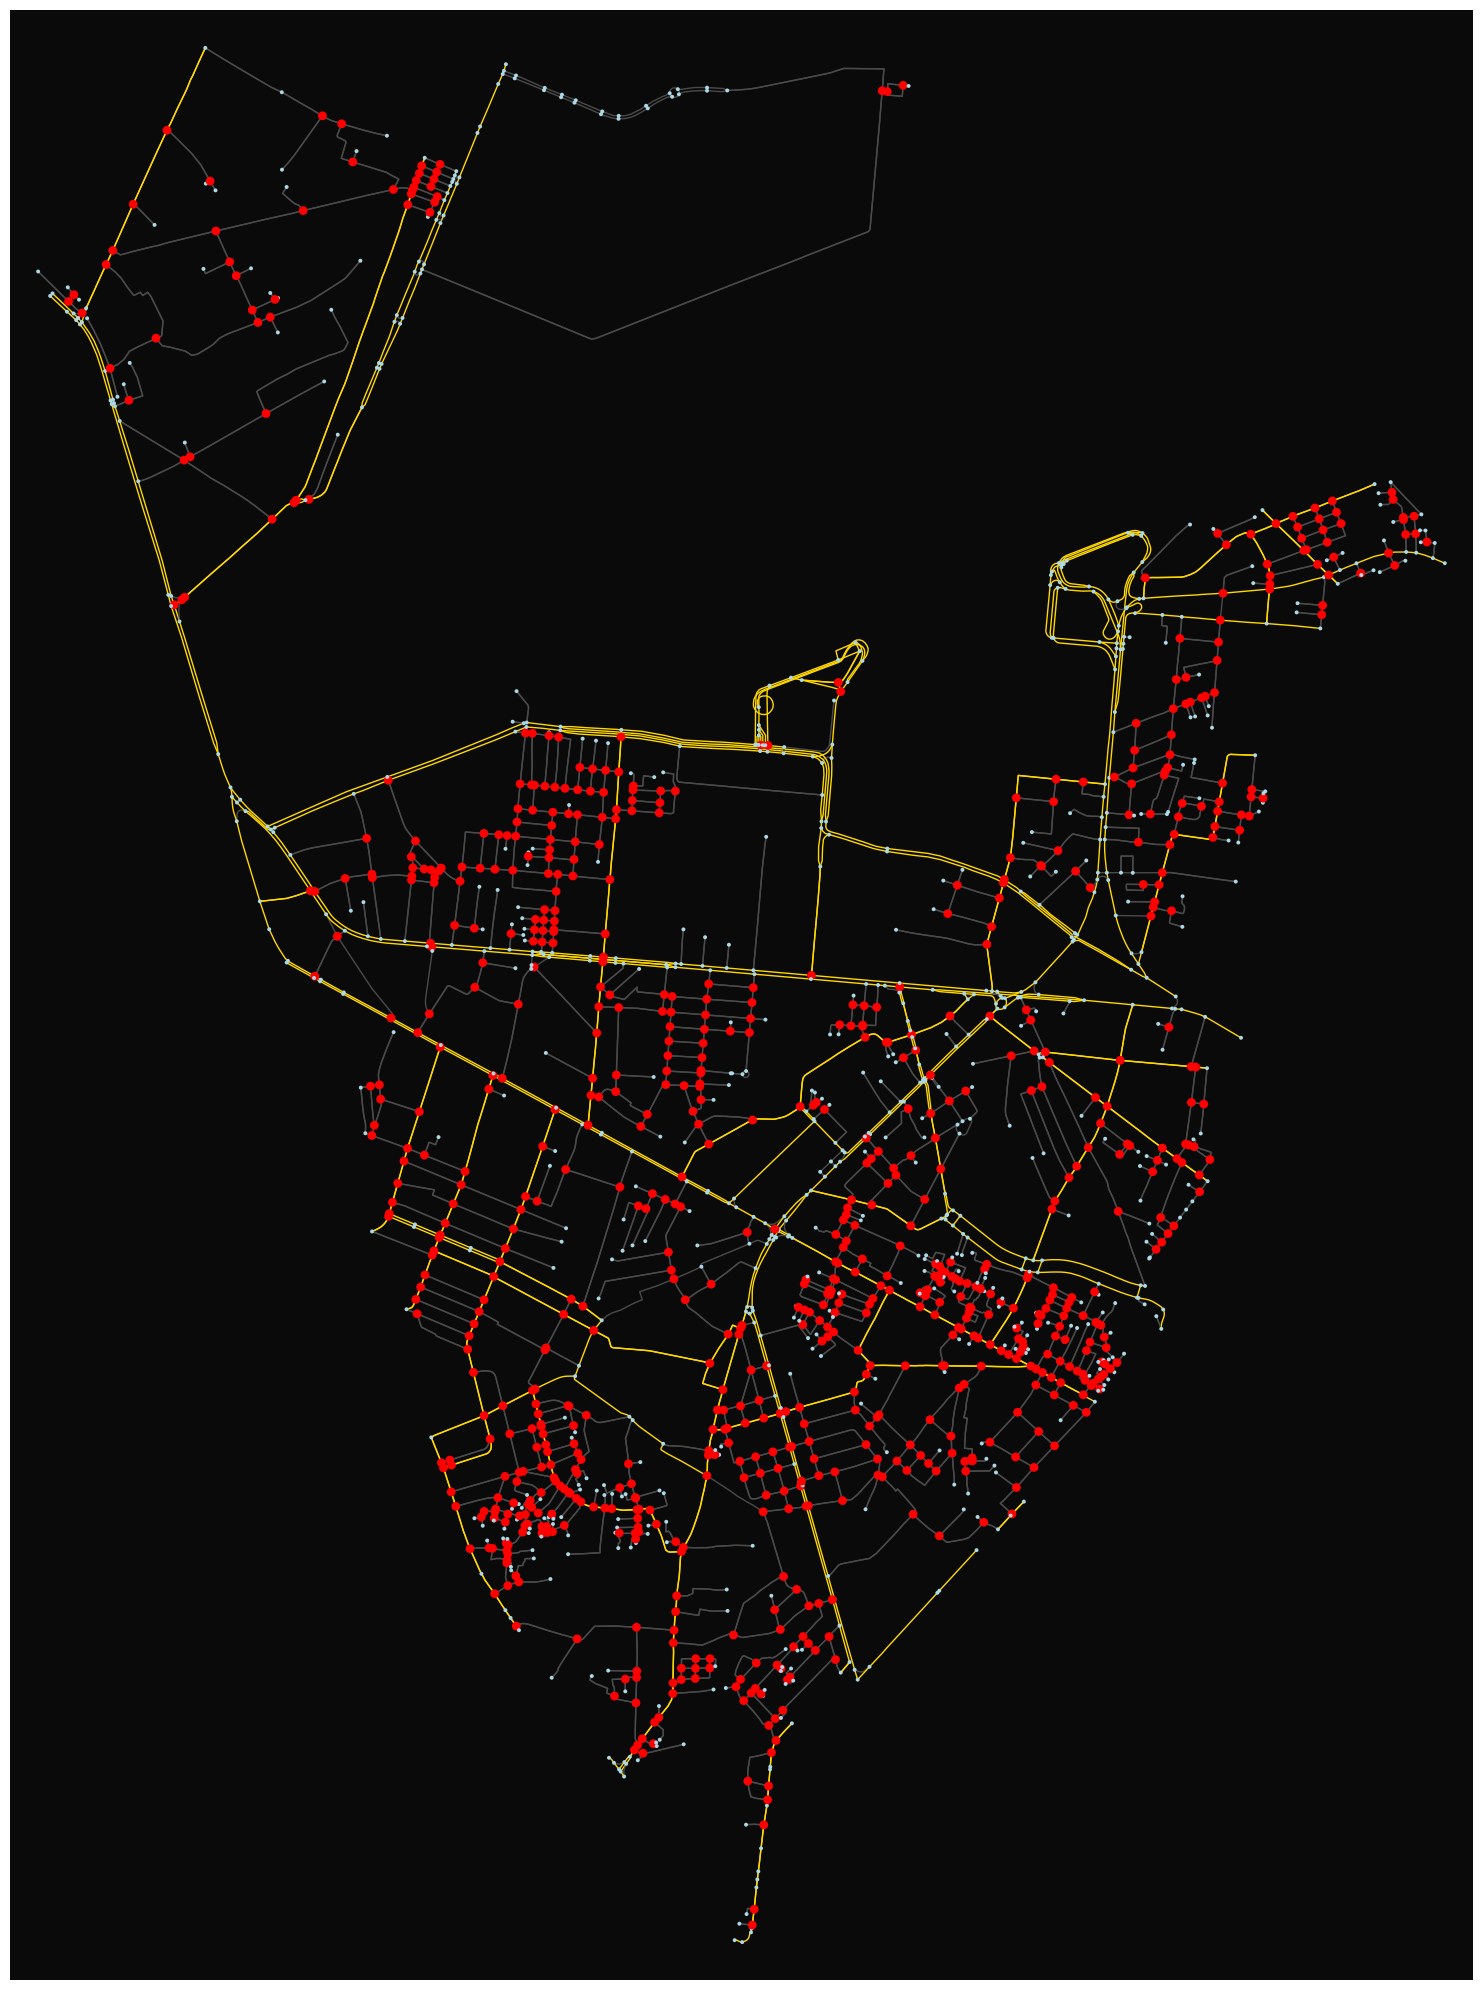

In [ ]:
# Visualization configuration
LARGE_NODE_THRESHOLD = 5    # Threshold for large nodes by degree
LARGE_NODE_SIZE = 40        # Size of large nodes
SMALL_NODE_SIZE = 8         # Size of small nodes
GRAPH_SIZE = (20, 20)       # Graph dimensions

def prepare_node_attributes(graph):
    """Prepare size and color attributes for nodes.

    New classification logic:
    - A node is considered a "large node" (major intersection) if ANY of the following is true:
        1) Its degree >= LARGE_NODE_THRESHOLD (keeps previous behavior), OR
        2) It connects to at least one major road (edge['is_major'] == True) AND its degree >= MIN_INTERSECTION_DEGREE
           (this makes intersections on major roads count as large even when degree is lower than the old threshold).
    - Otherwise the node is a small node.

    Parameters used:
    - LARGE_NODE_THRESHOLD: old degree-only threshold (keeps high-degree nodes large)
    - MIN_INTERSECTION_DEGREE: minimum branches to consider a meaningful intersection (defined earlier in the notebook)
    - edge['is_major']: flag set on edges previously (True for major roads)
    """
    node_sizes = []
    node_colors = []

    for node in graph.nodes:
        degree = graph.degree(node)

        # Count incident edges that are marked as major
        major_incident_count = 0
        for _u, _v, data in graph.edges(node, data=True):
            if data.get('is_major', False):
                major_incident_count += 1

        # Classification rule
        is_large = False
        # Keep original large-degree rule
        if degree >= LARGE_NODE_THRESHOLD:
            is_large = True
        # If node touches a major road and is a meaningful intersection (>= MIN_INTERSECTION_DEGREE), mark large
        elif (major_incident_count >= 1) and (degree >= MIN_INTERSECTION_DEGREE):
            is_large = True

        if is_large:
            node_sizes.append(LARGE_NODE_SIZE)
            node_colors.append('red')
        else:
            node_sizes.append(SMALL_NODE_SIZE)
            node_colors.append('lightblue')

    return node_sizes, node_colors


def get_edge_colors(graph):
    """Get colors for edges based on road type"""
    edge_colors = []

    for _, _, data in graph.edges(data=True):
        if data.get('is_major', False):
            edge_colors.append('#FFD700')  # Gold color for major roads
        else:
            edge_colors.append('#4A4A4A')  # Dark gray for minor roads

    return edge_colors


def visualize_graph(graph):
    """Plot graph with configured attributes"""
    node_sizes, node_colors = prepare_node_attributes(graph)
    edge_colors = get_edge_colors(graph)

    fig, ax = ox.plot_graph(
        graph,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color=edge_colors,
        bgcolor='#0a0a0a',
        show=False,
        close=False,
        figsize=GRAPH_SIZE
    )

    plt.tight_layout()
    plt.show()

# Plot graph with all roads
visualize_graph(G_big)